In [2]:
import os
from PIL import Image
from torchvision import transforms, datasets
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

import torchvision

import matplotlib.pyplot as plt

import torch.optim as optim

import numpy as np

from dataset import ImageDataset

from utils import class_imbalance, imshow

from sklearn.model_selection import KFold
import random

from model import ResNet_pt

torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Carregando os dados utilizando o custom Dataset

In [2]:
transformation = transforms.Compose([
    transforms.Resize((5616, 3744)), #Tamanho máximo das imagens
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.46], std=[0.25]) #Média e desvio padrão do dataset calculados com um script
])

root_dir = "../MLChallenge_Dataset/Data"
dataset = ImageDataset(root_dir,transform=transformation)

#divide o dataset em treino e teste

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#carrega o dataset de treino e teste

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#verifica o tamanho do dataset de treino e teste
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))

Train dataset size:  23268
Test dataset size:  5817


In [ ]:
#Testando se o dataset está carregando corretamente

images, labels = train_loader.dataset[0]
print(images.shape)

#show images
imshow(torchvision.utils.make_grid(images))

#show labels
print(f"Label: {labels}")


## Verificando se há class imbalance no dataset e resolvendo o problema utilizando oversampling

class_ratios: [0.67 0.33]


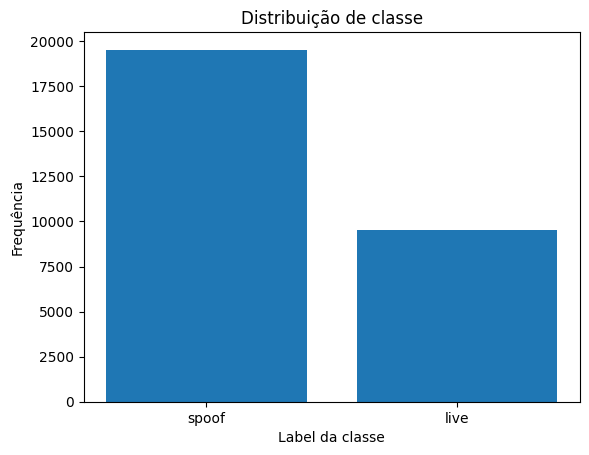

In [11]:
#Verificando se há class imbalance no dataset
#Label 0: spoof, Label 1: live
class_imbalance(train_dataset.dataset)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


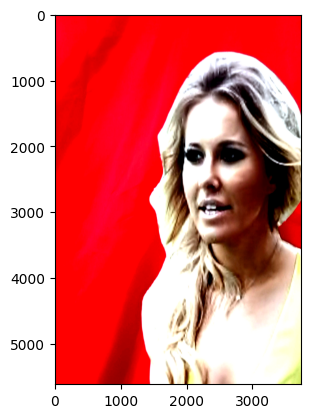

GroundTruth:  0
Predicted:  0


In [9]:
images, label = test_loader.dataset[40]

images = images.to(device)

#testando uma imagem

imshow(images)
print('GroundTruth: ', label)

outputs = model(images.unsqueeze(0))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', predicted.item())


## Avaliando o modelo treinado utilizando 5 K-Folds Cross Validation

In [4]:
#loading the model
import pickle
device = "cpu"

model = torch.load('output/k_cross_ResNet.pt')


In [5]:
torch.save(model.state_dict(), 'output/k_cross_ResNet_state_dict.pt')

torch.load('output/k_cross_ResNet_state_dict.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


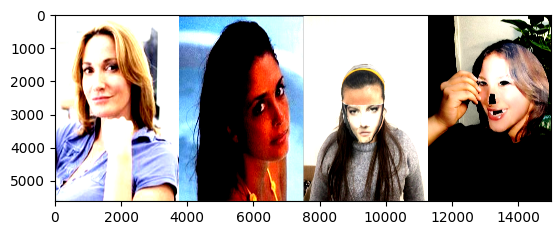

GroundTruth:      1     1     0     0


: 

: 

In [29]:
images, labels = [], []
for i in range(0,4):
    image, label = test_loader.dataset[i]
    images.append(image)
    labels.append(label)

#testando a rede

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs = model(torch.stack(images))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].item() for j in range(4)))

In [25]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     
     

Performance of 5 fold cross validation
Average Training Loss: 0.010 	 Average Test Loss: 0.010 	 Average Training Acc: 99.69 	 Average Test Acc: 99.65


In [26]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(10):
      diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
      diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
      diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
      diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))
     